In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import glob              # easy file searching
from PIL import Image    # image loading
import matplotlib.pyplot as plt
import scipy.io
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision.transforms import ToTensor
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import h5py
import math
import os
import torchvision as tv # data augmentation/loading utilities
from sklearn.model_selection import train_test_split
import scipy.io
import copy
import time
from tqdm.autonotebook import tqdm
from tempfile import TemporaryDirectory

<ipython-input-2-8230967616de>:22: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
# config
from easydict import EasyDict as edict
__C = edict()
__C.running_length = 10
cfg = __C
# __C.BATCH_SIZE = 64
BATCH_SIZE = 64
NUM_EPOCHS = 20
HISTORY_LENGTH = 10
PREDICTION_LENGTH = 5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
LEARNING_RATE = 0.3
FRAME_SIZE = 25 # 25 frames from 250 frames per second
FRAME_RATE = int(250/FRAME_SIZE)

cuda


In [ ]:
class Traces_6DOF_Dataset(torch.utils.data.Dataset):
  def __init__(self, path, transform=None, target_transform=None):
    super().__init__()
    # get filenames
    self.files = glob.glob(path)[0]
    self.transform = transform
    self.target_transform = target_transform


    # load grayscale images
    
    self.data = np.array(scipy.io.loadmat(self.files)['MMs1'],dtype='float32')[::FRAME_RATE,:]
    # normalization
    self.data[:,0] = self.data[:,0]/6
    self.data[:,1] = self.data[:,1]/4
    self.data[:,2] = self.data[:,2]/6
    self.data[:,3] = self.data[:,3]/180
    self.data[:,4] = self.data[:,4]/90
    self.data[:,5] = self.data[:,5]/90
    # define your transform
    # self.transform = tv.transforms.ToTensor()

  def __len__(self):
    return len(self.data)-(HISTORY_LENGTH+PREDICTION_LENGTH)*FRAME_SIZE

  def __getitem__(self, i):
    input = self.data[i:i+HISTORY_LENGTH*FRAME_SIZE,:]
    label = self.data[i+HISTORY_LENGTH*FRAME_SIZE:i+(HISTORY_LENGTH+PREDICTION_LENGTH)*FRAME_SIZE,:]
    # transform
    self.transform(input)
    self.target_transform(label)
    return input, label

In [ ]:
train_dataset = Traces_6DOF_Dataset('/content/drive/MyDrive/Traces_6DOF_NJIT/node2mobility.mat', transform=ToTensor(), target_transform=ToTensor())
val_dataset = Traces_6DOF_Dataset('/content/drive/MyDrive/Traces_6DOF_NJIT/node1mobility.mat', transform=ToTensor(), target_transform=ToTensor())
test_dataset = Traces_6DOF_Dataset('/content/drive/MyDrive/Traces_6DOF_NJIT/node5mobility.mat', transform=ToTensor(), target_transform=ToTensor())
# print(dataset[0])
# train_data, test_data = train_test_split_dataset(dataset, test_size=0.25)
print("train dataset size: ", len(train_dataset))

train dataset size:  2625


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

In [ ]:
print("train data shape[n_batch, seq_len, embedding_size]: ", len(train_dataloader), train_dataset[0][0].shape)

train data shape[n_batch, seq_len, embedding_size]:  41 (250, 6)


In [ ]:
# utilis
# checkpointing
def save_ckpt(fn, network, optimizer):
  torch.save({'net': network.state_dict(), 'opt': optimizer.state_dict()}, fn)

def load_ckpt(fn, network, optimizer):
  # ckpt = torch.load(fn,map_location=torch.device('cpu'))
  ckpt = torch.load(fn)
  network.load_state_dict(ckpt['net'])
  optimizer.load_state_dict(ckpt['opt'])
  return network, optimizer

In [ ]:
class Transformer(nn.Module):
    def __init__(
        self,
        embedding_size,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        forward_expansion,
        dropout,
        max_len,
        device,
    ):
        super(Transformer, self).__init__()
        self.src_position_embedding = nn.Embedding(max_len, embedding_size)
        self.trg_position_embedding = nn.Embedding(max_len, embedding_size)

        self.device = device
        self.transformer = nn.Transformer(
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            forward_expansion,
            dropout,
            batch_first=False
        )

        self.MLP = nn.Sequential(
          nn.Linear(6, 64),
          nn.ReLU(),
          nn.LayerNorm(64),
          nn.Linear(64, 128),
          nn.ReLU(embedding_size),
          nn.LayerNorm(128),
          nn.Linear(128, embedding_size),
        )
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(embedding_size, 6)

    def make_src_mask(self, src):
        src_mask = torch.Tensor(src.cpu().detach().numpy() == np.zeros((1,embedding_size),float))

        # (N, src_len)
        return src_mask.to(self.device)

    def forward(self, src, trg):
        src_seq_length, N,_ = src.shape
        trg_seq_length, N,_ = trg.shape

        src_positions = (
            torch.arange(0, src_seq_length)
            .unsqueeze(1)
            .expand(src_seq_length, N)
            .to(self.device)
        )
        # print("src position shape before pos: ", src_positions.shape)

        trg_positions = (
            torch.arange(0, trg_seq_length)
            .unsqueeze(1)
            .expand(trg_seq_length, N)
            .to(self.device)
        )
        embed_src = self.dropout(
            self.MLP(src) + self.src_position_embedding(src_positions)
        )
        # print("src: ", src[0][0])
        # print("position embedding: ", self.src_position_embedding(src_positions)[0][0])
        # print("embed src: ", embed_src[0][0])
        embed_trg = self.dropout(
            self.MLP(trg) + self.trg_position_embedding(trg_positions)
        )

        src_padding_mask = self.make_src_mask(embed_src)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_length).to(
            self.device
        )
        # print("trg_mask: ", trg_mask)
        # print("src_mask shape after pos: ", src_padding_mask.shape)
        # print("trg_mask shape after pos: ", trg_mask.shape)
        out = self.transformer(
            embed_src,
            embed_trg,
            # src_key_padding_mask=src_padding_mask,
            tgt_mask=trg_mask
        )
        # print("output", out)
        # print("output dtype before decode: ", out.dtype)
        # print("output shape before decode: ", out.shape)
        out = self.fc_out(out)
        return out

    def encode(self, src: Tensor):
        src_seq_length, N, _ = src.shape
        src_positions = (
            torch.arange(0, src_seq_length)
            .unsqueeze(1)
            .expand(src_seq_length, N)
            .to(self.device)
        ) 
        embed_src = self.MLP(src) + self.src_position_embedding(src_positions)
        embed_src = embed_src.to(self.device)
        src_padding_mask = self.make_src_mask(embed_src)
        return self.transformer.encoder(embed_src, src_padding_mask)

    def decode(self, trg: Tensor, memory: Tensor, trg_mask: Tensor):
        trg_seq_length, N,_ = trg.shape
        trg_positions = (
            torch.arange(0, trg_seq_length)
            .unsqueeze(1)
            .expand(trg_seq_length, N)
            .to(self.device)
        )
        embed_trg = self.MLP(trg) + self.trg_position_embedding(trg_positions)
        embed_trg = embed_trg.to(self.device)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_length).to(
            self.device
        )
        return self.transformer.decoder(embed_trg, memory,
                          trg_mask)



In [ ]:
# ntokens = 256  # embedding dimentsion of coordinates
input_size = HISTORY_LENGTH*FRAME_SIZE
output_size = PREDICTION_LENGTH*FRAME_SIZE
embedding_size = 200 # embedding dimension
forward_expansion = 512  # dimension of the feedforward network model in ``nn.TransformerEncoder``
num_encoder_layers = 6
num_decoder_layers = 6  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
num_heads = 8  # number of heads in ``nn.MultiheadAttention``
max_len = HISTORY_LENGTH*FRAME_SIZE
dropout = 0.1  # dropout probability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Transformer(
    embedding_size,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    forward_expansion,
    dropout,
    max_len,
    device,
).to(device=DEVICE)
criterion = nn.MSELoss()
lr = LEARNING_RATE  # learning rate
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, factor=0.1, patience=10
# )
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
batch_size = BATCH_SIZE
epochs = NUM_EPOCHS

In [ ]:
def train(model: nn.Module, data_loader, optimizer, scaler, writer, step) -> None:
    progress_bar = tqdm(data_loader)
    model.train() # turn on train mode
    total_loss = 0.
    start_time = time.time()
    num_batches = len(data_loader)
    log_interval = num_batches // 5
    return_loss = 0.
    for batch_idx, (data, targets) in enumerate(progress_bar):
        # print("batch index: ", batch_idx)
        # change src, tar shape from N,S,E to S,N,E to match batch_first=false
        data = data.permute(1, 0, 2)
        data = data.to(device=DEVICE)
        # print("data: ", data.shape)
        targets = targets.permute(1, 0, 2)
        targets = targets.to(device=DEVICE)
        # print("targets: ", targets.shape)
        # with torch.cuda.amp.autocast():
        output = model(data, targets)
        optimizer.zero_grad()
        loss = criterion(output, targets)
        # print(loss)
        # scaler.scale(loss).backward()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        # scaler.step(optimizer)
        optimizer.step()
        # scaler.update()
        writer.add_scalar("Training Loss", loss, global_step=step)
        step += 1

        total_loss += loss.item()
        return_loss += loss.item()
        progress_bar.set_postfix_str(f"training loss={loss.item():.3e}|avg training loss={total_loss/(batch_idx+1):.3e}")
        if batch_idx % log_interval == 0 and batch_idx > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            print(f'| epoch {epoch:3d} | {batch_idx:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f}')
            total_loss = 0
            start_time = time.time()
    return return_loss/(batch_idx+1)

def evaluate(model: nn.Module, dataloader: DataLoader) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    with torch.no_grad():
        for (data, targets) in dataloader:
            data = data.permute(1, 0, 2)
            targets = targets.permute(1, 0, 2)
            data = data.to(device=DEVICE)
            targets = targets.to(device=DEVICE)

            output = model(data, targets)
            # output_flat = output.view(-1, output_size)
            total_loss += criterion(output, targets).item()
            # print("val loss: ", total_loss)
            # data = data.permute(1, 0, 2) #.detach().cpu().numpy()
            # output = output.permute(1, 0, 2) #.detach().cpu().numpy()
            # print("output2: ", output[0][0])
    return total_loss / (len(dataloader) - 1)


In [ ]:
LOAD_MODEL = False
# training
if LOAD_MODEL:
    load_ckpt("/content/drive/MyDrive/checkpoints_new20.pt", model, optimizer)

# with TemporaryDirectory() as tempdir:
#     best_model_params_path = os.path.join(tempdir, "best_model_params.pt")
scaler = torch.cuda.amp.GradScaler()
print(scaler)
training_loss = []
validation_loss = []
best_val_loss = float('inf')
writer = SummaryWriter("run/loss_plot")
step = 0
for epoch in range(1, NUM_EPOCHS+1):
    print(f'Epoch #{epoch}')
    epoch_start_time = time.time()
    train_loss = train(model, train_dataloader, optimizer, scaler, writer, step)
    # print(train_loss)
    training_loss.append(train_loss)
    mean_loss = sum(training_loss)/len(training_loss)
    val_loss = evaluate(model, val_dataloader)
    validation_loss.append(val_loss)
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
        f'valid loss {mean_loss:5.2f} | mean loss {mean_loss:8.2f}')
    print('-' * 89)
    if mean_loss < best_val_loss:
        best_val_loss = mean_loss
        # save model
        save_ckpt("/content/drive/MyDrive/checkpoints_new20.pt", model, optimizer)
    # scheduler.step(mean_loss)
    scheduler.step()
# load_ckpt("/content/drive/MyDrive/checkpoints.pt", model, optimizer)
      


Epoch #1


  0%|          | 0/41 [00:00<?, ?it/s]

| epoch   1 |     8/   41 batches | lr 0.30 | ms/batch 408.37 | loss 1882.26
| epoch   1 |    16/   41 batches | lr 0.30 | ms/batch 351.72 | loss  9.21
| epoch   1 |    24/   41 batches | lr 0.30 | ms/batch 343.93 | loss  6.21
| epoch   1 |    32/   41 batches | lr 0.30 | ms/batch 343.42 | loss  7.30
| epoch   1 |    40/   41 batches | lr 0.30 | ms/batch 345.50 | loss  2.52
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 14.39s | valid loss 372.19 | mean loss   372.19
-----------------------------------------------------------------------------------------
Epoch #2


  0%|          | 0/41 [00:00<?, ?it/s]

| epoch   2 |     8/   41 batches | lr 0.28 | ms/batch 405.14 | loss  0.74
| epoch   2 |    16/   41 batches | lr 0.28 | ms/batch 346.27 | loss  0.60
| epoch   2 |    24/   41 batches | lr 0.28 | ms/batch 345.61 | loss  0.30
| epoch   2 |    32/   41 batches | lr 0.28 | ms/batch 346.16 | loss  0.30
| epoch   2 |    40/   41 batches | lr 0.28 | ms/batch 350.92 | loss  0.65
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 14.41s | valid loss 186.35 | mean loss   186.35
-----------------------------------------------------------------------------------------
Epoch #3


  0%|          | 0/41 [00:00<?, ?it/s]

| epoch   3 |     8/   41 batches | lr 0.27 | ms/batch 400.07 | loss  0.71
| epoch   3 |    16/   41 batches | lr 0.27 | ms/batch 347.98 | loss  0.58
| epoch   3 |    24/   41 batches | lr 0.27 | ms/batch 345.57 | loss  0.17
| epoch   3 |    32/   41 batches | lr 0.27 | ms/batch 349.58 | loss  0.13
| epoch   3 |    40/   41 batches | lr 0.27 | ms/batch 358.91 | loss  0.35
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 14.46s | valid loss 124.36 | mean loss   124.36
-----------------------------------------------------------------------------------------
Epoch #4


  0%|          | 0/41 [00:00<?, ?it/s]

| epoch   4 |     8/   41 batches | lr 0.26 | ms/batch 395.03 | loss  0.23
| epoch   4 |    16/   41 batches | lr 0.26 | ms/batch 347.98 | loss  0.17
| epoch   4 |    24/   41 batches | lr 0.26 | ms/batch 348.70 | loss  0.13
| epoch   4 |    32/   41 batches | lr 0.26 | ms/batch 355.16 | loss  0.13
| epoch   4 |    40/   41 batches | lr 0.26 | ms/batch 362.57 | loss  0.50
-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 14.52s | valid loss 93.33 | mean loss    93.33
-----------------------------------------------------------------------------------------
Epoch #5


  0%|          | 0/41 [00:00<?, ?it/s]

| epoch   5 |     8/   41 batches | lr 0.24 | ms/batch 391.67 | loss  0.38
| epoch   5 |    16/   41 batches | lr 0.24 | ms/batch 348.50 | loss  0.09
| epoch   5 |    24/   41 batches | lr 0.24 | ms/batch 350.14 | loss  0.14
| epoch   5 |    32/   41 batches | lr 0.24 | ms/batch 367.12 | loss  0.10
| epoch   5 |    40/   41 batches | lr 0.24 | ms/batch 356.58 | loss  0.14
-----------------------------------------------------------------------------------------
| end of epoch   5 | time: 14.55s | valid loss 74.69 | mean loss    74.69
-----------------------------------------------------------------------------------------
Epoch #6


  0%|          | 0/41 [00:00<?, ?it/s]

| epoch   6 |     8/   41 batches | lr 0.23 | ms/batch 391.50 | loss  0.36
| epoch   6 |    16/   41 batches | lr 0.23 | ms/batch 348.81 | loss  0.32
| epoch   6 |    24/   41 batches | lr 0.23 | ms/batch 351.16 | loss  0.45
| epoch   6 |    32/   41 batches | lr 0.23 | ms/batch 365.23 | loss  1.40
| epoch   6 |    40/   41 batches | lr 0.23 | ms/batch 352.18 | loss  0.43
-----------------------------------------------------------------------------------------
| end of epoch   6 | time: 14.52s | valid loss 62.34 | mean loss    62.34
-----------------------------------------------------------------------------------------
Epoch #7


  0%|          | 0/41 [00:00<?, ?it/s]

| epoch   7 |     8/   41 batches | lr 0.22 | ms/batch 394.61 | loss  0.29
| epoch   7 |    16/   41 batches | lr 0.22 | ms/batch 350.00 | loss  0.22
| epoch   7 |    24/   41 batches | lr 0.22 | ms/batch 355.38 | loss  0.55
| epoch   7 |    32/   41 batches | lr 0.22 | ms/batch 364.99 | loss  0.26
| epoch   7 |    40/   41 batches | lr 0.22 | ms/batch 347.77 | loss  0.28
-----------------------------------------------------------------------------------------
| end of epoch   7 | time: 14.56s | valid loss 53.48 | mean loss    53.48
-----------------------------------------------------------------------------------------
Epoch #8


  0%|          | 0/41 [00:00<?, ?it/s]

| epoch   8 |     8/   41 batches | lr 0.21 | ms/batch 395.00 | loss  0.12
| epoch   8 |    16/   41 batches | lr 0.21 | ms/batch 349.82 | loss  0.05
| epoch   8 |    24/   41 batches | lr 0.21 | ms/batch 364.18 | loss  0.55
| epoch   8 |    32/   41 batches | lr 0.21 | ms/batch 357.41 | loss  0.26
| epoch   8 |    40/   41 batches | lr 0.21 | ms/batch 350.16 | loss  0.56
-----------------------------------------------------------------------------------------
| end of epoch   8 | time: 14.58s | valid loss 46.83 | mean loss    46.83
-----------------------------------------------------------------------------------------
Epoch #9


  0%|          | 0/41 [00:00<?, ?it/s]

| epoch   9 |     8/   41 batches | lr 0.20 | ms/batch 394.85 | loss  0.12
| epoch   9 |    16/   41 batches | lr 0.20 | ms/batch 357.78 | loss  0.05
| epoch   9 |    24/   41 batches | lr 0.20 | ms/batch 362.14 | loss  0.03
| epoch   9 |    32/   41 batches | lr 0.20 | ms/batch 352.37 | loss  0.08
| epoch   9 |    40/   41 batches | lr 0.20 | ms/batch 349.46 | loss  0.19
-----------------------------------------------------------------------------------------
| end of epoch   9 | time: 14.59s | valid loss 41.64 | mean loss    41.64
-----------------------------------------------------------------------------------------
Epoch #10


  0%|          | 0/41 [00:00<?, ?it/s]

| epoch  10 |     8/   41 batches | lr 0.19 | ms/batch 394.60 | loss  0.12
| epoch  10 |    16/   41 batches | lr 0.19 | ms/batch 356.78 | loss  0.12
| epoch  10 |    24/   41 batches | lr 0.19 | ms/batch 357.17 | loss  0.08
| epoch  10 |    32/   41 batches | lr 0.19 | ms/batch 352.64 | loss  0.15
| epoch  10 |    40/   41 batches | lr 0.19 | ms/batch 351.71 | loss  0.23
-----------------------------------------------------------------------------------------
| end of epoch  10 | time: 14.57s | valid loss 37.49 | mean loss    37.49
-----------------------------------------------------------------------------------------
Epoch #11


  0%|          | 0/41 [00:00<?, ?it/s]

| epoch  11 |     8/   41 batches | lr 0.18 | ms/batch 398.56 | loss  0.08
| epoch  11 |    16/   41 batches | lr 0.18 | ms/batch 362.39 | loss  0.08
| epoch  11 |    24/   41 batches | lr 0.18 | ms/batch 352.49 | loss  0.07
| epoch  11 |    32/   41 batches | lr 0.18 | ms/batch 354.57 | loss  0.19
| epoch  11 |    40/   41 batches | lr 0.18 | ms/batch 351.94 | loss  0.46
-----------------------------------------------------------------------------------------
| end of epoch  11 | time: 14.60s | valid loss 34.10 | mean loss    34.10
-----------------------------------------------------------------------------------------
Epoch #12


  0%|          | 0/41 [00:00<?, ?it/s]

| epoch  12 |     8/   41 batches | lr 0.17 | ms/batch 406.68 | loss  0.12
| epoch  12 |    16/   41 batches | lr 0.17 | ms/batch 358.57 | loss  0.31
| epoch  12 |    24/   41 batches | lr 0.17 | ms/batch 351.83 | loss  0.29
| epoch  12 |    32/   41 batches | lr 0.17 | ms/batch 353.46 | loss  0.19
| epoch  12 |    40/   41 batches | lr 0.17 | ms/batch 351.42 | loss  0.23
-----------------------------------------------------------------------------------------
| end of epoch  12 | time: 14.64s | valid loss 31.27 | mean loss    31.27
-----------------------------------------------------------------------------------------
Epoch #13


  0%|          | 0/41 [00:00<?, ?it/s]

| epoch  13 |     8/   41 batches | lr 0.16 | ms/batch 414.83 | loss  0.11
| epoch  13 |    16/   41 batches | lr 0.16 | ms/batch 352.56 | loss  0.13
| epoch  13 |    24/   41 batches | lr 0.16 | ms/batch 353.94 | loss  0.08
| epoch  13 |    32/   41 batches | lr 0.16 | ms/batch 355.68 | loss  0.07
| epoch  13 |    40/   41 batches | lr 0.16 | ms/batch 356.73 | loss  0.16
-----------------------------------------------------------------------------------------
| end of epoch  13 | time: 14.71s | valid loss 28.88 | mean loss    28.88
-----------------------------------------------------------------------------------------
Epoch #14


  0%|          | 0/41 [00:00<?, ?it/s]

| epoch  14 |     8/   41 batches | lr 0.15 | ms/batch 410.34 | loss  0.56
| epoch  14 |    16/   41 batches | lr 0.15 | ms/batch 353.26 | loss  0.22
| epoch  14 |    24/   41 batches | lr 0.15 | ms/batch 352.85 | loss  0.07
| epoch  14 |    32/   41 batches | lr 0.15 | ms/batch 355.21 | loss  0.11
| epoch  14 |    40/   41 batches | lr 0.15 | ms/batch 366.38 | loss  0.32
-----------------------------------------------------------------------------------------
| end of epoch  14 | time: 14.76s | valid loss 26.83 | mean loss    26.83
-----------------------------------------------------------------------------------------
Epoch #15


  0%|          | 0/41 [00:00<?, ?it/s]

| epoch  15 |     8/   41 batches | lr 0.15 | ms/batch 399.31 | loss  0.13
| epoch  15 |    16/   41 batches | lr 0.15 | ms/batch 353.22 | loss  0.08
| epoch  15 |    24/   41 batches | lr 0.15 | ms/batch 354.61 | loss  0.07
| epoch  15 |    32/   41 batches | lr 0.15 | ms/batch 360.30 | loss  0.09
| epoch  15 |    40/   41 batches | lr 0.15 | ms/batch 361.39 | loss  0.27
-----------------------------------------------------------------------------------------
| end of epoch  15 | time: 14.69s | valid loss 25.05 | mean loss    25.05
-----------------------------------------------------------------------------------------
Epoch #16


  0%|          | 0/41 [00:00<?, ?it/s]

| epoch  16 |     8/   41 batches | lr 0.14 | ms/batch 399.04 | loss  0.38
| epoch  16 |    16/   41 batches | lr 0.14 | ms/batch 352.63 | loss  0.75
| epoch  16 |    24/   41 batches | lr 0.14 | ms/batch 354.32 | loss  0.42
| epoch  16 |    32/   41 batches | lr 0.14 | ms/batch 366.56 | loss  0.08
| epoch  16 |    40/   41 batches | lr 0.14 | ms/batch 359.88 | loss  0.27
-----------------------------------------------------------------------------------------
| end of epoch  16 | time: 14.71s | valid loss 23.51 | mean loss    23.51
-----------------------------------------------------------------------------------------
Epoch #17


  0%|          | 0/41 [00:00<?, ?it/s]

| epoch  17 |     8/   41 batches | lr 0.13 | ms/batch 401.19 | loss  0.11
| epoch  17 |    16/   41 batches | lr 0.13 | ms/batch 353.91 | loss  0.21
| epoch  17 |    24/   41 batches | lr 0.13 | ms/batch 357.97 | loss  0.33
| epoch  17 |    32/   41 batches | lr 0.13 | ms/batch 370.92 | loss  0.26
| epoch  17 |    40/   41 batches | lr 0.13 | ms/batch 355.18 | loss  0.30
-----------------------------------------------------------------------------------------
| end of epoch  17 | time: 14.76s | valid loss 22.14 | mean loss    22.14
-----------------------------------------------------------------------------------------
Epoch #18


  0%|          | 0/41 [00:00<?, ?it/s]

| epoch  18 |     8/   41 batches | lr 0.13 | ms/batch 399.79 | loss  0.13
| epoch  18 |    16/   41 batches | lr 0.13 | ms/batch 354.26 | loss  0.08
| epoch  18 |    24/   41 batches | lr 0.13 | ms/batch 363.52 | loss  0.05
| epoch  18 |    32/   41 batches | lr 0.13 | ms/batch 366.24 | loss  0.13
| epoch  18 |    40/   41 batches | lr 0.13 | ms/batch 354.60 | loss  0.55
-----------------------------------------------------------------------------------------
| end of epoch  18 | time: 14.76s | valid loss 20.92 | mean loss    20.92
-----------------------------------------------------------------------------------------
Epoch #19


  0%|          | 0/41 [00:00<?, ?it/s]

| epoch  19 |     8/   41 batches | lr 0.12 | ms/batch 400.56 | loss  0.16
| epoch  19 |    16/   41 batches | lr 0.12 | ms/batch 359.08 | loss  0.07
| epoch  19 |    24/   41 batches | lr 0.12 | ms/batch 365.27 | loss  0.05
| epoch  19 |    32/   41 batches | lr 0.12 | ms/batch 358.12 | loss  0.10
| epoch  19 |    40/   41 batches | lr 0.12 | ms/batch 353.08 | loss  0.22
-----------------------------------------------------------------------------------------
| end of epoch  19 | time: 14.72s | valid loss 19.82 | mean loss    19.82
-----------------------------------------------------------------------------------------
Epoch #20


  0%|          | 0/41 [00:00<?, ?it/s]

| epoch  20 |     8/   41 batches | lr 0.11 | ms/batch 401.62 | loss  0.25
| epoch  20 |    16/   41 batches | lr 0.11 | ms/batch 362.14 | loss  0.11
| epoch  20 |    24/   41 batches | lr 0.11 | ms/batch 360.72 | loss  0.07
| epoch  20 |    32/   41 batches | lr 0.11 | ms/batch 358.77 | loss  0.12
| epoch  20 |    40/   41 batches | lr 0.11 | ms/batch 353.35 | loss  0.40
-----------------------------------------------------------------------------------------
| end of epoch  20 | time: 14.73s | valid loss 18.84 | mean loss    18.84
-----------------------------------------------------------------------------------------


In [ ]:
def predict(model, input):
    model.train()
    trg_input = torch.unsqueeze(input[-1], 0)
    num_tokens = len(input[0])
    for _ in range(0,50):
          # Get source mask
          trg_mask = model.transformer.generate_square_subsequent_mask(PREDICTION_LENGTH*FRAME_SIZE).to(
            DEVICE
          )
          pred = model(input, trg_input)
          # print(pred)
          next_item = pred[0] # num with highest probability
          next_item = torch.unsqueeze(next_item,0)
          trg_input = torch.vstack((trg_input, next_item))
    return trg_input[1:]

In [ ]:
input_arr = []
output_arr = []
targets_arr = []
for (data, targets) in test_dataloader:
    input = torch.unsqueeze(data[0],1).to(DEVICE)
    target = torch.unsqueeze(targets[0],1).to(DEVICE)
    pred = predict(model, input)
    input_arr.append(data)
    output_arr.append(pred)
    targets_arr.append(target)

OutOfMemoryError: ignored

In [ ]:
print(training_loss)
epochs = range(1, len(training_loss)+1)
plt.figure()
plt.plot(epochs, torch.tensor(training_loss).numpy(), label='Training Loss')
# plt.plot(epochs, torch.tensor(validation_loss).numpy(), label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

NameError: ignored

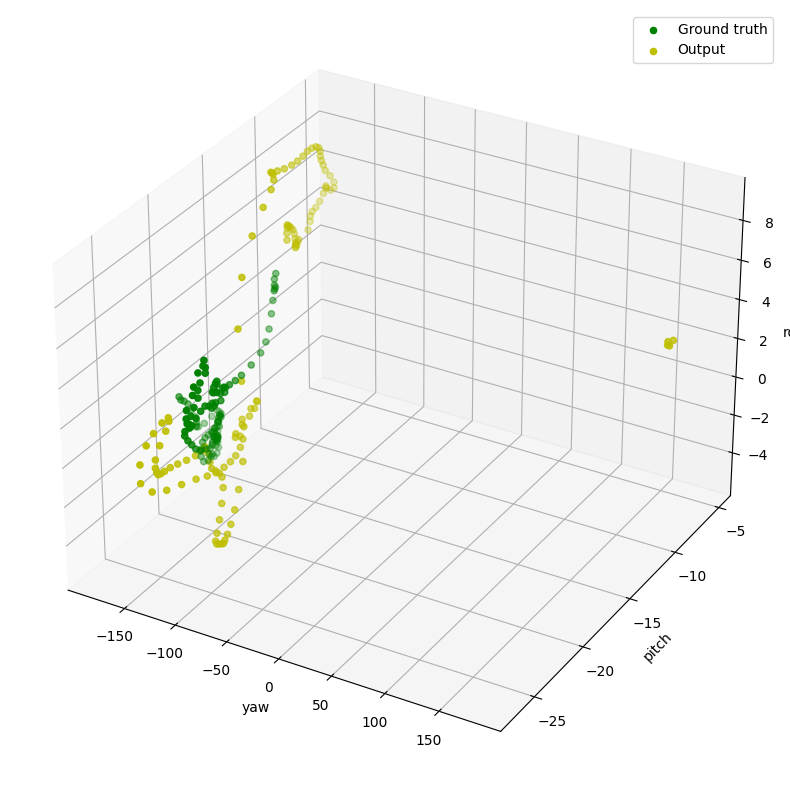

In [ ]:
yaw1 = torch.squeeze(torch.stack(output_arr))[1,:,3].detach().cpu().numpy()*180
pitch1 = torch.squeeze(torch.stack(output_arr))[1,:,4].detach().cpu().numpy()*90
roll1 = torch.squeeze(torch.stack(output_arr))[1,:,5].detach().cpu().numpy()*90
yaw = torch.squeeze(torch.stack(targets_arr))[1,:,3].detach().cpu().numpy()*180
pitch = torch.squeeze(torch.stack(targets_arr))[1,:, 4].detach().cpu().numpy()*90
roll = torch.squeeze(torch.stack(targets_arr))[1,:, 5].detach().cpu().numpy()*90
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
G = ax.scatter(yaw, pitch, roll, c='g', marker='o')
O = ax.scatter(-yaw1, pitch1, roll1, c='y', marker='o')
plt.legend((G,O),('Ground truth','Output'))
ax.set_xlabel('yaw')
ax.set_ylabel('pitch')
ax.set_zlabel('roll')
plt.show()
# fig.savefig('fig/oo_1.png')